In [1]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt

from pprint import pprint
from Algorithms.ddpg import config

# 0. Plot Setting

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# 1. Model Setting

## 1.1 Load Config

In [3]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('tmp_config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [4]:
ntb_mode = True
double_ddpg = True

env_kwargs.update({
    'reward_fn': 'mean var',
    'reward_fn_kwargs': {},
    'reward_mode': 'pnl'
})

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'std_coeff': 0.05
})

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,
    'double_ddpg': double_ddpg,
})

learn_kwargs.update({
    'total_timesteps': 1500
})

# del model_kwargs['std_coeff']

if ntb_mode:
    actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
    critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}


    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32],
                     'qf': [(nn.BatchNorm1d, 'bn'), 2]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

else:
    model_kwargs['policy_kwargs'].update({
        'net_arch': [],
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 2,
        'net_arch': [32, 64]
    })

model_kwargs['policy_kwargs']['one_asset'] = (env_kwargs['n_assets']==1)

# model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
#     'features_in': 5
# })

In [5]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

env 'BSMarket was created!
model_kwargs['env']: <BSMarket instance>
env 'BSMarket was created!
learn_kwargs['eval_env']: <BSMarketEval instance>
learn_kwargs['tb_log_name']: ddpg_220615-2134
learn_kwargs['eval_log_path']: ../logs/tb_logs/ddpg_220615-2134_1


In [6]:
pprint(env_kwargs)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 0.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 1000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [7]:
pprint(model_kwargs)

{'action_noise': NormalActionNoise(mu=0.0, sigma=0.1),
 'batch_size': 15,
 'buffer_size': 300,
 'create_eval_env': False,
 'device': 'auto',
 'env': <Env.env.BSMarket object at 0x000002284FB5C1F0>,
 'gamma': 0.99,
 'gradient_steps': -1,
 'learning_rate': <function lr_schedule at 0x000002284F984B80>,
 'learning_starts': 300,
 'optimize_memory_usage': False,
 'policy': <class 'Algorithms.ddpg.policies.DoubleDDPGPolicy'>,
 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   'actor_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'critic_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'double_ddpg': True,
                   'features_extractor_class': <class 'Env.feature_extractor.MarketObsExtractor'>,
                   'features_extractor_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                                                 'features_in': 4,
                        

In [8]:
pprint(learn_kwargs)

{'callback': <Algorithms.ddpg.callbacks.ReportCallbacks object at 0x000002284FAE6FD0>,
 'eval_env': <Env.env.BSMarketEval object at 0x0000022818FF2A30>,
 'eval_freq': 30,
 'eval_log_path': '../logs/tb_logs/ddpg_220615-2134_1',
 'log_interval': 30,
 'n_eval_episodes': 1,
 'reset_num_timesteps': True,
 'tb_log_name': 'ddpg_220615-2134',
 'total_timesteps': 1500}


## 1.2 Make env, model

In [9]:
from Algorithms.ddpg import DoubleDDPG
from stable_baselines3.ddpg import DDPG
# from Algorithms.ddpg.double_ddpg import DDPG

# model = DoubleDDPG(**model_kwargs)
model = DoubleDDPG(**model_kwargs)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
model.policy

DoubleDDPGPolicy(
  (actor): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=4, out_features=32, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
      )
    )
    (mu): Sequential(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=64, out_features=32, bias=True)
      (2): ReLU()
      (3): Linear(in_features=32, out_features=32, bias=True)
      (4): ReLU()
      (5): Linear(in_features=32, out_features=2, bias=True)
      (6): Tanh()
    )
    (flatten): Flatten(start_dim=-2, end_dim=-1)
  )
  (actor_target): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequent

# 2. Learning

In [11]:
model = model.learn(**learn_kwargs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/tb_logs\ddpg_220615-2134_1
[Training Start]
Eval num_timesteps=30, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0155  |
| time/              |          |
|    total timesteps | 30       |
---------------------------------
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0162  |
| time/              |          |
|    total timesteps | 60       |
---------------------------------
Eval num_timesteps=90, episode_reward=-0.01 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mea

In [12]:
config.save_config(f'{learn_kwargs["eval_log_path"]}/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarket instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.ddpg.callbacks.ReportCallbacks object at 0x000002284FAE6FD0> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/ddpg_220615-2134_1/config.yaml was saved.


# 3. P&L Evaluation

In [13]:
# model = model.load('../logs/tb_logs/ddpg_220607-2214_stable'+'/best_model')
# model = model.load('../logs/tb_logs/ddpg_220607-2124_ntb_delta'+'/best_model')
# model = model.load('../logs/tb_logs/ddpg_220608-2037_1'+'/best_model')
# model = model.load('../logs/tb_logs/ddpg_220614-2216_1_ntb_pnl'+'/best_model')
# model = model.load('../logs/tb_logs/ddpg_220614-2213_1_ddpg_pnl'+'/best_model')
model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
print(learn_kwargs['eval_log_path'] + '/best_model')

../logs/tb_logs/ddpg_220615-2134_1/best_model


In [14]:
eval_env = learn_kwargs['eval_env']
eval_env.reward_mode = 'pnl'

In [15]:
import numpy as np

# random_pnl = np.mean([eval_env.pnl_eval() for _ in range(30)], axis=0)
# delta_pnl = np.mean([eval_env.delta_eval() for _ in range(30)], axis=0)
# rl_pnl = np.mean([eval_env.pnl_eval(model) for _ in range(30)], axis=0)

# random_pnl = np.load('best_results/random_pnl.npy')
# delta_pnl = np.load('best_results/ntb_pnl.npy')
rl_pnl = np.load('best_results/rl_pnl_0614.npy')
# rl_pnl = np.load('best_results/rl_pnl_eval_cash.npy')
# ntb_pnl = np.load('best_results/ntb_pnl_eval_cash.npy')

In [16]:
# np.save('best_results/rl_pnl_0614', ntb_pnl)
# np.save('best_results/delta_pnl', delta_pnl)
# np.save('best_results/rl_pnl', rl_pnl)

In [17]:
ntb_pnl = np.mean([eval_env.pnl_eval(model) for _ in range(30)], axis=0)

In [23]:
import numpy as np

def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return mean - 0.02 * std , (mean, std)

def sharpe_ratio(pnl):
    return pnl.mean()/pnl.std()

def var(pnl, ratio):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return losses[boundary]

def cvar(pnl, ratio=0.95):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return np.mean(losses[boundary:], axis=-1)

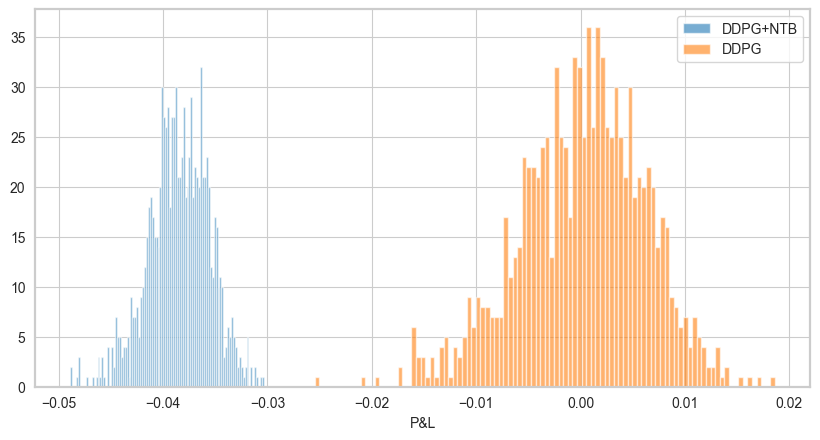

ntb pnl:		-0.0386, -0.0385, 0.0029
rl pnl:		-0.0000, 0.0001, 0.0061
ntb sharpe:		-13.05847
rl sharpe:		0.01507
ntb cvar:		0.04529
rl cvar:		0.01384


In [24]:
plt_kwargs = {'bins': 100,
              # 'range': (-0.04, 0.01),
              'alpha': 0.6}

plt.xlabel('P&L')
# plt.hist(random_pnl, bins=100, range=(-0.25, 0.05), alpha=0.6, label='random')
# plt.hist(random_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='random')
# plt.hist(delta_pnl, **plt_kwargs, label='delta')
plt.hist(ntb_pnl,**plt_kwargs, label='DDPG+NTB')
plt.hist(rl_pnl, **plt_kwargs, label='DDPG')
# plt.ylim(0, 150)
plt.legend()
plt.show()

# r1, (m1, s1) = pnl_reward(random_pnl)
r2, (m2, s2) = pnl_reward(ntb_pnl)
r3, (m3, s3) = pnl_reward(rl_pnl)
# print(f'random:\t{r1:.4f}, {m1:.4f}, {s1:.4f}')
print(f'ntb pnl:\t\t{r2:.4f}, {m2:.4f}, {s2:.4f}')
print(f'rl pnl:\t\t{r3:.4f}, {m3:.4f}, {s3:.4f}')
# print((r2-r1))
# print((r3-r2))

print(f'ntb sharpe:\t\t{sharpe_ratio(ntb_pnl):.5f}')
print(f'rl sharpe:\t\t{sharpe_ratio(rl_pnl):.5f}')

print(f'ntb cvar:\t\t{cvar(ntb_pnl):.5f}')
print(f'rl cvar:\t\t{cvar(rl_pnl):.5f}')

In [12]:
ntb_pnl.mean(), ntb_pnl.std()

(-0.022955209587592933, 0.00333743451844443)

In [13]:
rl_pnl.mean(), rl_pnl.std()

(-0.022750967764943068, 0.006194732383409264)

In [25]:
np.save('best_results/ntb_pnl_0614', ntb_pnl)

In [31]:
np.save('best_results/rl_pnl_eval_cash', rl_pnl,)
np.save('best_results/ntb_pnl_eval_cash', ntb_pnl,)

In [55]:
from Utils.prices import pnl_entropic_loss

def loss(pnl, aversion=0.0):
    return np.mean((1-np.exp(-aversion * pnl))/(aversion+1e-7))

print(loss(ntb_pnl, aversion=1.1))
print(loss(rl_pnl, aversion=1.1))

-0.023253765816845084
-0.02307192182905543


In [14]:
import pandas as pd

ntb_loss = pd.Series(-ntb_pnl)
rl_loss = pd.Series(-rl_pnl)

var95_ntb = ntb_loss.quantile(0.95)
var95_rl = rl_loss.quantile(0.95)

print(var95_ntb, var95_rl)

0.02867360759284007 0.03344846486958373


In [15]:
print(ntb_loss[ntb_loss >= var95_ntb].mean())

0.030563063997726295


In [16]:
print(rl_loss[rl_loss >= var95_rl].mean())

0.03678241960186988


In [23]:
print(cvar(ntb_pnl, 0.95), cvar(rl_pnl, 0.95))

0.030563063997726295 0.03678241960186988


In [27]:
th.randn(3,4).shape[-1]

4

In [18]:
rl_pnl = ntb_pnl.copy()

## New Problem

총 얼마 썼는가?


In [32]:
import numpy as np

def cash_eval(env, model=None):
    obs = env.reset()
    done, info = False, {}
    cash = 0
    while not done:
        if model:
            action, _ = model.predict(obs, deterministic=False)
        else:
            action = env.action_space.sample()

        obs, reward, done, info = env.cashflow_pnl(action)
        cash += info['raw_reward']
        print(np.mean(info['raw_reward']))

    return cash

In [22]:
ntb_cash = np.load('best_results/ntb_cash_0614.npy')

In [23]:
rl_cash = np.mean([cash_eval(eval_env, model) for _ in range(30)], axis=0)

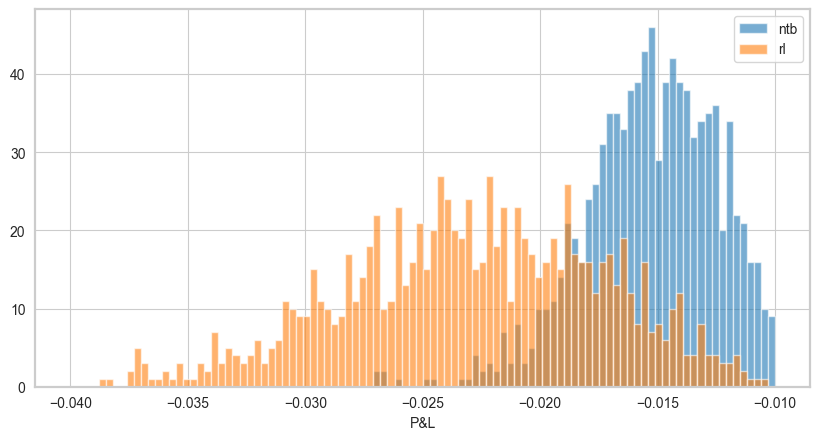

ntb_pnl:	-0.0152, -0.0151, 0.0030
rl:		-0.0230, -0.0229, 0.0057


In [25]:
plt_kwargs = {'bins': 100,
              'range': (-0.04, -0.01),
              'alpha': 0.6}

plt.xlabel('P&L')
plt.hist(ntb_cash,**plt_kwargs, label='ntb')
plt.hist(rl_cash, **plt_kwargs, label='rl')
# plt.ylim(0, 150)
plt.legend()
plt.show()

# r1, (m1, s1) = pnl_reward(random_pnl)
r2, (m2, s2) = pnl_reward(ntb_cash)
r3, (m3, s3) = pnl_reward(rl_cash)
# print(f'random:\t{r1:.4f}, {m1:.4f}, {s1:.4f}')
print(f'ntb_pnl:\t{r2:.4f}, {m2:.4f}, {s2:.4f}')
print(f'rl:\t\t{r3:.4f}, {m3:.4f}, {s3:.4f}')
# print((r2-r1))

In [53]:
np.save('best_results/ntb_cash_0614', ntb_cash)